# Mean-Variance Portfolio Optimization 

This is a strategy aimed at maximizing the rewards for a given level of risk in portfolio allocation. The principle is to balance risk and reward - to strive for the highest possible return without accepting an inefficient amount of risk relative to the market. This approach aids in determining the optimal portfolio allocation, focusing on gaining the highest returns for the lowest risk. It's all about identifying the sweet spot on the Efficient Frontier - the place where risk and return balance each other out for peak portfolio efficiency.

In [ ]:
%pip install yfinance

In [ ]:
%pip install nbformat

In [3]:
# Cool data
import yfinance as yf

# The usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [36]:
# Create a portfolio
# symbols = [
#     'AAPL',
#     'MSFT',
#     'META',
#     'AMZN',
#     'XOM',
#     'UNH',
#     'JNJ',
#     'V',
#     'HD',
#     'ABBV',
#     'KO',
#     'DIS',
#     'T',
#     'UPS',
#     'LMT',
#     'CAT',
#     'F',
#     'MAR',
#     'O',
#     'HSY'
# ]

symbols = [
    'TSLA',
    'MSFT',
    'NVDA',
    'GOOGL',
    'CRSP'
]

In [37]:
# Get stock data
data = yf.download(symbols, start='2018-01-01', end='2023-07-25')
data.head()

[*********************100%***********************]  5 of 5 completed


Adj Close                                                  Close  \
                 CRSP      GOOGL       MSFT       NVDA       TSLA       CRSP   
Date                                                                           
2018-01-02  25.170000  53.660500  80.562050  49.321178  21.368668  25.170000   
2018-01-03  23.520000  54.576000  80.936996  52.567204  21.150000  23.520000   
2018-01-04  23.910000  54.787998  81.649345  52.844303  20.974667  23.910000   
2018-01-05  26.809999  55.514500  82.661636  53.292118  21.105333  26.809999   
2018-01-08  26.070000  55.710499  82.745995  54.925022  22.427334  26.070000   

                                                        ...       Open  \
                GOOGL       MSFT       NVDA       TSLA  ...       CRSP   
Date                                                    ...              
2018-01-02  53.660500  85.949997  49.837502  21.368668  ...  24.000000   
2018-01-03  54.576000  86.349998  53.117500  21.150000  ...  24.100000   
2018-01-04  54.787998  87.110001  53.397499  20.974667  ...  23.990000   
2018-01-05  55.514500  88.190002  53.849998  21.105333  ...  23.580000   
2018-01-08  55.710499  88.279999  55.500000  22.427334  ...  23.799999   

                                                         Volume            \
                GOOGL       MSFT       NVDA       TSLA     CRSP     GOOGL   
Date                                                                        
2018-01-02  52.651001  86.129997  48.945000  20.799999  1223100  31766000   
2018-01-03  53.696499  86.059998  51.025002  21.400000  1065100  31318000   
2018-01-04  54.854500  86.589996  53.939999  20.858000   708400  26052000   
2018-01-05  55.172501  87.660004  53.547501  21.108000  3994900  30250000   
2018-01-08  55.549999  88.199997  55.099998  21.066668  1798500  24644000   

                                           
                MSFT      NVDA       TSLA  
Date                                       
2018-01-02  22483800  35561600   65283000  
2018-01-03  26061400  91470400   67822500  
2018-01-04  21912000  58326800  149194500  
2018-01-05  23407100  58012400   68868000  
2018-01-08  22113000  88121600  147891000  

[5 rows x 30 columns]

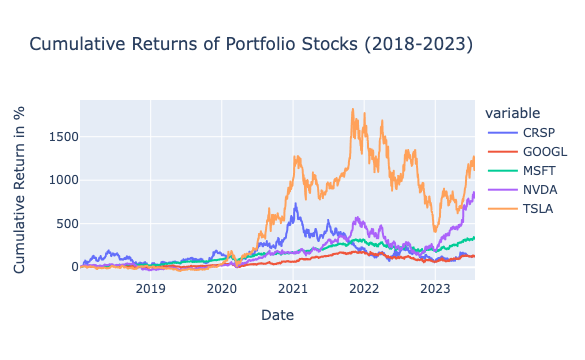

In [38]:
# Visualize cumulative returns of each stock in the portfolio
portfolio_returns = data['Adj Close'].pct_change().dropna()

port_comps_rets_cumprod = portfolio_returns.add(1).cumprod().sub(1)*100

fig = px.line(port_comps_rets_cumprod,
              x=port_comps_rets_cumprod.index,
              y=port_comps_rets_cumprod.columns,
              title='Cumulative Returns of Portfolio Stocks (2018-2023)')

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')

fig.show()

In [39]:
# Import S & P 500 data and plot cumulative returns for performance comparison
sp_index = yf.download('^GSPC', start='2018-01-01', end='2023-07-25')
sp_index.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000


<Axes: >

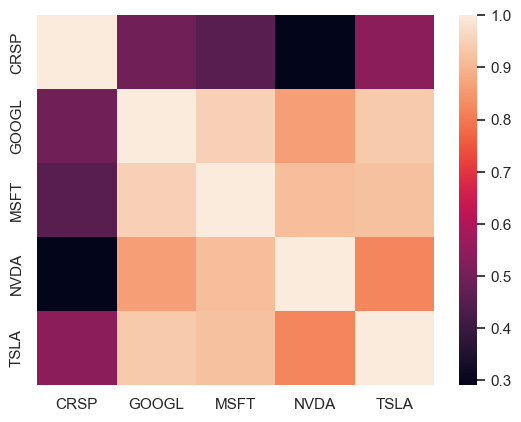

In [40]:
# Create a correlation heatmap to visualize portfolio asset neutrality
port_corr = port_comps_rets_cumprod.corr()

sns.heatmap(port_corr)

## Optimization

In [ ]:
%pip install PyPortfolioOpt

In [12]:
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.plotting import plot_weights
from pypfopt.cla import CLA

In [41]:
# Partition data into train and test
train = portfolio_returns[:'2021-05-30']
test = portfolio_returns['2021-05-31':]

# Exponential moving average
mu = expected_returns.ema_historical_return(train, returns_data=True, span=500)

# Exponential covariant
Sigma = risk_models.exp_cov(train, returns_data=True, span=500)

In [42]:
mu

CRSP     0.816581
GOOGL    0.585962
MSFT     0.442765
NVDA     0.980923
TSLA     2.195140
Name: 2021-05-28 00:00:00, dtype: float64

In [43]:
mu_max = mu.max()

ret_ef = np.arange(0, mu_max, 0.01)
vol_ef = []

for i in np.arange(0, mu_max, 0.01):
    ef = EfficientFrontier(mu, Sigma)
    ef.efficient_return(i)
    vol_ef.append(ef.portfolio_performance()[1])

In [44]:
ef = EfficientFrontier(mu, Sigma)
ef.min_volatility()
min_vol_ret = ef.portfolio_performance()[0]
min_vol_vol = ef.portfolio_performance()[1]

In [45]:
ef = EfficientFrontier(mu, Sigma)
ef.max_sharpe(risk_free_rate=0.009)
max_sharpe_ret = ef.portfolio_performance()[0]
max_sharpe_vol = ef.portfolio_performance()[1]

/Users/ryanzola/Documents/Web/python/simple_moving_average/simple_moving_average_env/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning:

The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.



Text(0.5, 1.0, 'Efficeint Frontier')

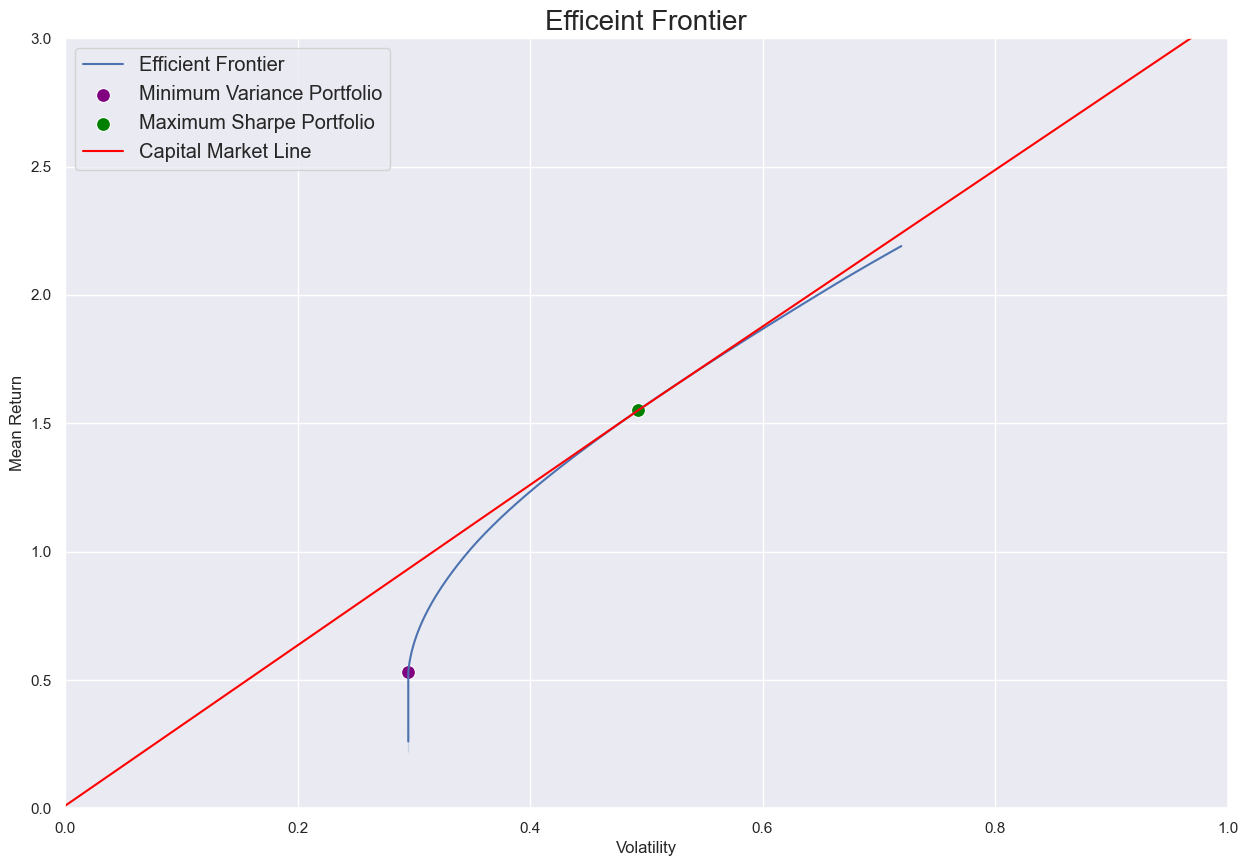

In [49]:
sns.set()

fix, ax = plt.subplots(figsize = [15, 10])

# Plot Efficient Frontier
sns.lineplot(x = vol_ef, y = ret_ef,
             label = 'Efficient Frontier',
             ax = ax)

# Plot portfolio with minimum variance
sns.scatterplot(x = [min_vol_vol], y=[min_vol_ret],
                ax = ax,
                label = 'Minimum Variance Portfolio',
                color = 'purple', s = 100)

# Plot maximum sharpe portfolio
sns.scatterplot(x = [max_sharpe_vol], y = [max_sharpe_ret],
                ax = ax,
                label = 'Maximum Sharpe Portfolio',
                color = 'green', s = 100)

sns.lineplot(x = [0, max_sharpe_vol, 1], 
             y = [0.009, max_sharpe_ret, 3.096],
             ax = ax,
             label = 'Capital Market Line',
             color = 'red')

ax.set(xlim = [0, 1])
ax.set(ylim = [0, 3])
ax.set_xlabel('Volatility')
ax.set_ylabel('Mean Return')
plt.legend(fontsize='large')
plt.title('Efficeint Frontier', fontsize='20')

Essentially, just trying to pick a portfolio that stays on this efficient frontier so that no matter how much volatility that is taken on, algorithmically, I should be getting average returns that are efficient to the market capital for the chosen stocks.

Expected annual return: 52.9%
Annual volatility: 29.5%
Sharpe Ratio: 1.76


(0.5291529412339238, 0.29529690132257236, 1.76145749889101)

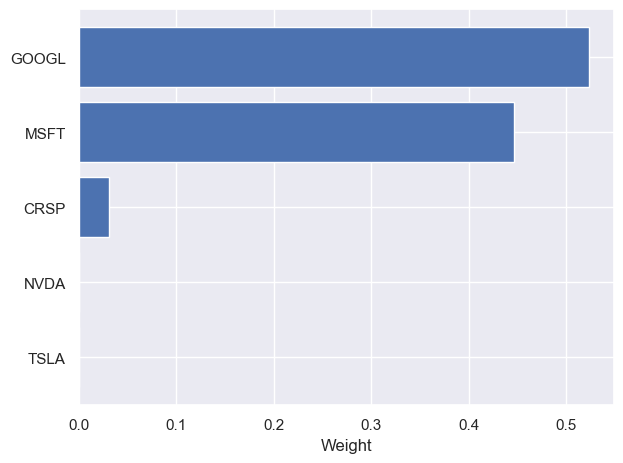

In [51]:
# Minimum Variance: Less volatility, more consistent returns
ef = EfficientFrontier(mu, Sigma)
raw_weights_minvar_exp = ef.min_volatility()

plot_weights(raw_weights_minvar_exp)
ef.portfolio_performance(verbose=True, risk_free_rate=0.009)

Expected annual return: 155.0%
Annual volatility: 49.3%
Sharpe Ratio: 3.13


(1.5503098015676002, 0.4930837643146622, 3.1258579436495317)

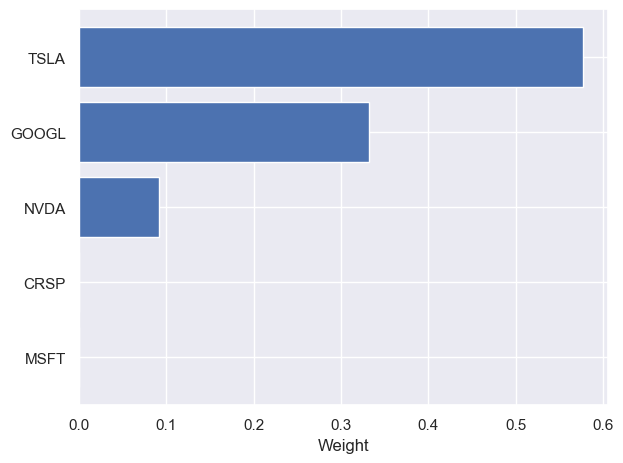

In [52]:
# Maximum Sharpe: Taking on more volatility for more rewards
ef = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe_exp = ef.max_sharpe(risk_free_rate=0.009)

plot_weights(raw_weights_maxsharpe_exp)
ef.portfolio_performance(verbose=True, risk_free_rate=0.009)

## Backtesting

In [53]:
weights_minvar_exp = list(raw_weights_minvar_exp.values())
weights_maxsharpe_exp = list(raw_weights_maxsharpe_exp.values())

ret_1 = test.dot(weights_minvar_exp).add(1).cumprod().subtract(1).multiply(100)
ret_2 = test.dot(weights_maxsharpe_exp).add(1).cumprod().subtract(1).multiply(100)

ind_ret = sp_index['2021-05-31':]['Adj Close'].pct_change().add(1).cumprod().subtract(1).multiply(100)

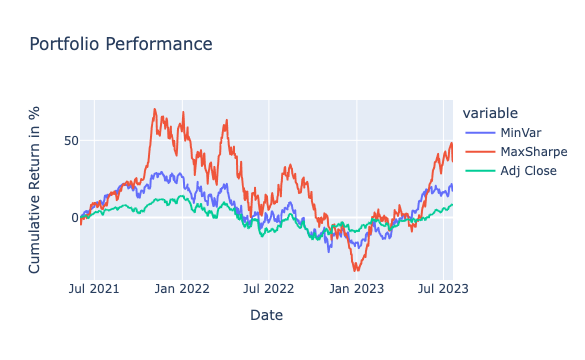

In [54]:
back = pd.DataFrame({'MinVar':ret_1, 'MaxSharpe':ret_2})
back = pd.concat([back, ind_ret], join='outer', axis=1)
back.drop(back.tail(1).index, inplace=True)

back.interpolate(method='linear', inplace=True)

fig = px.line(back, x=back.index, y=back.columns, title='Portfolio Performance')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')

fig.show()